In [ ]:
!pip install --upgrade pip -- quiet
!pip install torch torchvision ftfy regex tqdm -- quiet
!pip install git+https://github.com/openai/CLIP.git -- quiet

  Using cached torch-2.7.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached regex-2024.11.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-

In [ ]:
! pip install faiss-cpu -- quiet

  Using cached faiss_cpu-1.11.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (4.8 kB)
Using cached faiss_cpu-1.11.0-cp312-cp312-manylinux_2_28_x86_64.whl (31.3 MB)


In [5]:
import os
import torch
import clip
from PIL import Image
import numpy as np
import faiss
from tqdm import tqdm
from pathlib import Path
import shutil

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

## Helper functions

In [6]:
def embed_image(path):
    img = Image.open(path).convert("RGB")
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = model.encode_image(img_tensor)
    emb = emb.cpu().numpy().astype('float32')
    faiss.normalize_L2(emb)
    return emb

## copying camera angle and indexing images

The code snippet below can be used to specify a camera angle, else it'll run on all photos in the dir

In [ ]:
'''
# isolate specific camera angle
folder = "./image_data_b/halo_filtered"
camera_filter = ("cam5D4F399F.jpg", ".cam1.jpg", ".cam0.jpg")
cam_1_images = Path("./image_data_b/cam_filtered")

# make dir if it doesn't exist
cam_1_images.mkdir(parents=True, exist_ok=True)

for root, dirs, files in os.walk(folder):
    for file in files:
        if file.lower().endswith(".jpg"):
            if any(filter in file for filter in camera_filter):
                src = Path(root) / file
                dst = cam_2_images / file
    
                shutil.copy(str(src), str(dst))
'''                

In [ ]:
folder = "./image_data_b/halo_filtered"
paths = [os.path.join(folder, f)
         for f in os.listdir(folder)
         if f.lower().endswith((".jpg"))]

emb_dim = 512
embeddings = np.zeros((len(paths), emb_dim), dtype='float32')

for idx, p in enumerate(tqdm(paths, desc="Embedding images")):
    embeddings[idx] = embed_image(p)

Embedding images: 100%|██████████| 46745/46745 [49:49<00:00, 15.64it/s]


## Query image...

In [8]:
index = faiss.IndexFlatIP(emb_dim)
index.add(embeddings)

In [ ]:
q_emb = embed_image("./GI_Iceflow_Model/ice_image.jpg")
D, I = index.search(q_emb, k = 3000) # find top 10 matches

results = [(paths[i], float(D[0][j])) for j, i in enumerate(I[0])]

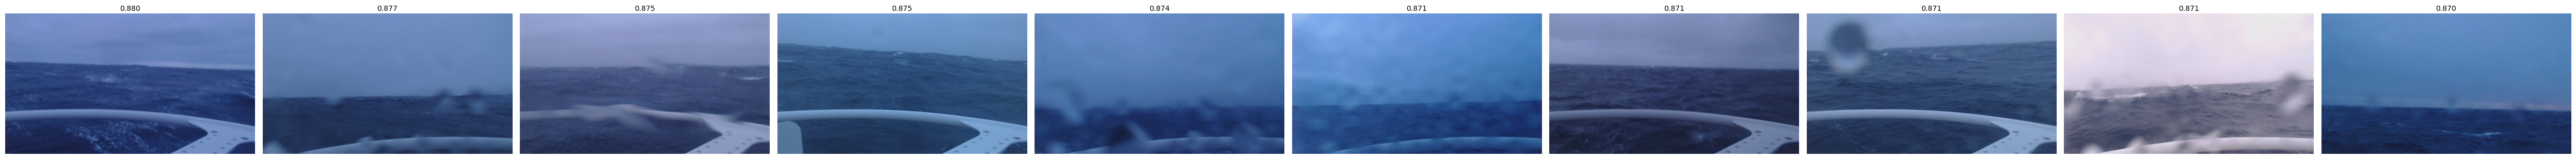

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

top5 = results[:10]
fig, axes = plt.subplots(1, len(top5), figsize=(5 * len(top5), 5))
axes = axes if hasattr(axes, "__iter__") else [axes]

for ax, (fp, score) in zip(axes, top5):
    img = Image.open(fp)
    ax.imshow(img)
    ax.set_title(f"{score:.3f}", fontsize=10, pad=4)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
with open ("similarity_results_b.txt", "w") as f:
    for idx, path in enumerate(results):
        f.write(f"{results[idx][0]}\n")

In [91]:
! rm -rf /home/jovyan/GI_Iceflow_Model/image_matches_b
! rm -rf /home/jovyan/GI_Iceflow_Model/image_matches_b.tar.gz

In [ ]:
### move matches to a different directory
matching_dir = "./image_matches_b"
os.makedirs(matching_dir, exist_ok=True)
paths_file = "./similarity_results_b.txt"


Useful links;
https://medium.com/aimonks/image-similarity-with-dinov2-and-faiss-741744bc5804
https://medium.com/%40heyitssandeep/how-i-built-an-image-search-engine-with-clip-and-faiss-5b48df1df0fa

In [12]:
try:
    with open(paths_file, "r") as file:
        for line in file:
            src = line.strip()
            dst = matching_dir

            shutil.copy(str(src), str(dst))

except Exception as e:
    print(f"Can't copy file: {e}")

In [ ]:
# ! tar -zcf image_matches_b.tar.gz image_matches_b

In [ ]:
### iceflow image path RTC:ooi/uncabled/GI01SUMO/R00005/cg_data/dcl13/vics-hourly